# Forming Queries with Rasters

### Let's get part of raster dataset centered on a point

   depth site_id            pit_id  bottom_depth comments sample_a sample_b  \
0   67.0     1N3  COGM1N3_20200211          64.0     None     None     None   

  sample_c   value flags  ...        date                     time_created  \
0     None  < 1 mm  None  ...  2020-02-11 2024-08-13 17:45:41.685272+00:00   

   time_updated       id                                   doi  date_accessed  \
0          None  2147814  https://doi.org/10.5067/DUD2VZEVBJ7S     2022-06-30   

  instrument        type units observers  
0       None  grain_size  None      None  

[1 rows x 29 columns]
[datetime.date(2020, 2, 2), datetime.date(2020, 2, 13)]


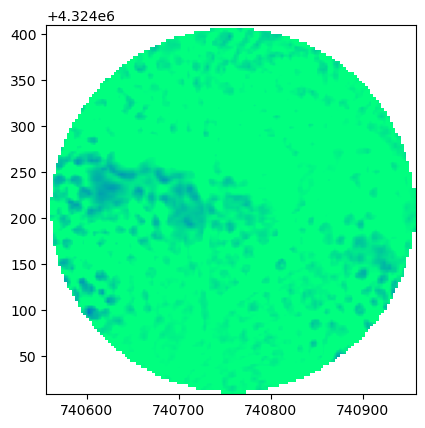

<Axes: >

In [1]:
from snowexsql.api import RasterMeasurements, LayerMeasurements
from datetime import date
from rasterio.plot import show
from rasterio.plot import show


# Pick a site ID
site_id = '1N3'
df_site = LayerMeasurements.from_filter(site_id=site_id, limit=1)
print(df_site)

# Pick a date 
dates = RasterMeasurements.from_unique_entries(["date"], observers='ASO Inc.', type='depth')
print(dates)

# Subset a raster on our buffered point!
ds = RasterMeasurements.from_area(pt=df_site.geometry[0], buffer=200, observers='ASO Inc.', type='depth', date=dates[0])
show(ds, vmin=0, vmax=0.8, cmap='winter')

<open DatasetReader name='/vsimem/a5c827f3-b18d-4ed8-9776-21fb75877c64/a5c827f3-b18d-4ed8-9776-21fb75877c64.tif' mode='r'>


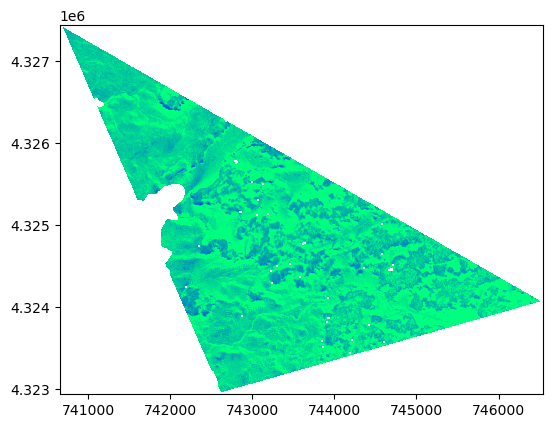

<Axes: >

In [2]:
from snowexsql.api import RasterMeasurements, LayerMeasurements
from shapely.geometry import Polygon
import geopandas as gpd


# Lets form a triangle using site IDs
site_id = ['2S6', '2C2', '8N45']

# Grab the unique locations for these 
locations = LayerMeasurements.from_unique_entries(['easting', 'northing'],
                                                site_id=site_id)

triangle = Polygon(locations)
ds = RasterMeasurements.from_area(shp=triangle, observers='ASO Inc.', type='depth',
                                  date=date(2020, 2, 2))
print(ds)
show(ds, vmin=0, vmax=1, cmap='winter')

## Recap
Isolating raster datasets can enable users to build out workflows using minimal data from snowex. 

**You should know**
* How `RasterMeasurements.from_*` differ from `PointMeasurements.from*` or `LayerMeasurements.from*`